En esta práctica, implementaremos nuestro propio **Sistema de Gestión de Bases de Datos (SGDB)** para un modelo de bases de datos sencillo basado en archivos de texto. En este modelo, los datos consisten únicamente en una clave primaria numérica y un valor asociado. A lo largo del enunciado, nos referiremos a cada tupla de clave-valor como _registro_.

La base de datos que desarrollaremos es de tipo *append_only*: la información se añade al final del archivo correspondiente cada vez que introduzcamos nuevos datos. Cuando consultemos información sobre una clave específica, devolveremos el valor correspondiente al último registro con esa clave.

**Conceptos Clave**: Programación en Python, Gestión de Archivos, Rendimiento, Sistemas de Gestión de Bases de Datos, Índices.

La práctica está dividida en varios apartados, en los que iremos añadiendo funcionalidades de forma incremental. Se recomienda que, al completar cada apartado, probéis que todo funciona correctamente antes de avanzar al siguiente. El apartado final del proyecto consiste en medir el rendimiento de todas las extensiones, por lo que **es imprescindible** mantener cada subapartado en un archivo independiente. La evaluación se centrará en los apartados **1.4** y **1.5**, valorándose tanto la eficiencia como la legibilidad del código.

## 1.1

En el primer apartado, crearemos las siguientes funciones para gestionar las tablas de nuestra base de datos:

- `nombre_tabla2archivo(nombre_tabla: str) -> str`: devuelve el archivo asociado a la tabla con nombre `nombre_tabla`.

- `leer(clave: int, nombre_tabla: str) -> str`: lee de la tabla `nombre_tabla` el último valor asociado a la clave `clave`.

- `escribir(clave: int, valor: str, nombre_tabla: str)`: escribe en la tabla con nombre `nombre_tabla` la clave `clave` y su valor asociado `valor`.
 
Probad con ejemplos sencillos la creación de distintas tablas y las operaciones correspondientes.

## 1.2

En el apartado anterior, observamos que el uso de funciones puras resulta engorroso: debemos generar el nombre del archivo en cada operación, lo que acopla nuestro código. Para simplificar, crearemos una clase `Tabla1_2` que encapsule la gestión de una tabla concreta. Esta clase extenderá la clase abstracta `TablaBase`, unificando así los métodos necesarios para todas las extensiones. Incluye cuatro métodos a implementar:

- `leer(clave: int) -> str`: lee de la tabla asociada el último valor asociado a la clave `clave`.
- `escribir(self, clave: int, valor: str)`: escribe en la tabla la clave y el valor especificados.

- `procesar_operaciones(self, archivo: str) -> None`: procesa la secuencia de operaciones de lectura y escritura en el archivo con nombre `archivo`, donde cada línea es de la forma:

    - `l <clave>`: devuelve de la tabla el valor asociado a la clave `<clave>` y lo imprime por pantalla.
    - `e <clave> <valor>`: introduce en la tabla el valor `<valor>` asociado a la clave `<clave>`.

- `tiempos(self) -> List[Tuple[str, float]]`: devuelve una lista con todas las operaciones realizadas y el tiempo que tomaron. Cada elemento de la lista es de la forma `(<operacion>, <tiempo>)`, donde `<operacion>` es el tipo (`"l"` o `"e"`) y `<tiempo>` es el tiempo en segundos.

El script `generar_archivos_ejecucion.py` permite generar secuencias de operaciones aleatorias para probar ejemplos y medir el rendimiento. Los parámetros configurables son:

- **NUM_COMMANDS**: número de comandos en el archivo.
- **MAX_CLAVES**: número máximo de claves distintas.
- **MAX_SIZE_VALOR**: tamaño máximo del valor en bytes.
- **READ_PROB**: probabilidad (entre 0 y 1) de realizar una operación de lectura. La probabilidad de escritura es $1 - $**READ_PROB**.

Experimentad con distintos valores para evaluar el impacto en el rendimiento.

## 1.3

La implementación actual es ineficiente, ya que buscar elementos implica recorrer todas las claves hasta encontrar la deseada. Para mejorar la velocidad de lectura, implementaremos un _pseudo-índice_. Este índice, representado por un diccionario, almacenará la posición en el archivo del último valor introducido para cada clave. Así, podremos leer los valores directamente desde el archivo. 

Para manejar este diccionario, utilizaremos los métodos de archivos (archivo `f`):

- `f.tell()`: devuelve la siguiente posición en la que el cursor actual va a empezar a leer/escribir.
- `f.seek(n)`: nos permite mover el cursor de un fichero a la posición `n`.

Implementad la clase `Tabla1_3`, que gestione este diccionario y lo mantenga actualizado.

**NOTA**: os puede ayudar utilizar el método `f.readline()` para generar un índice cuando carguéis una tabla ya existente.

_Ejemplo de índice_

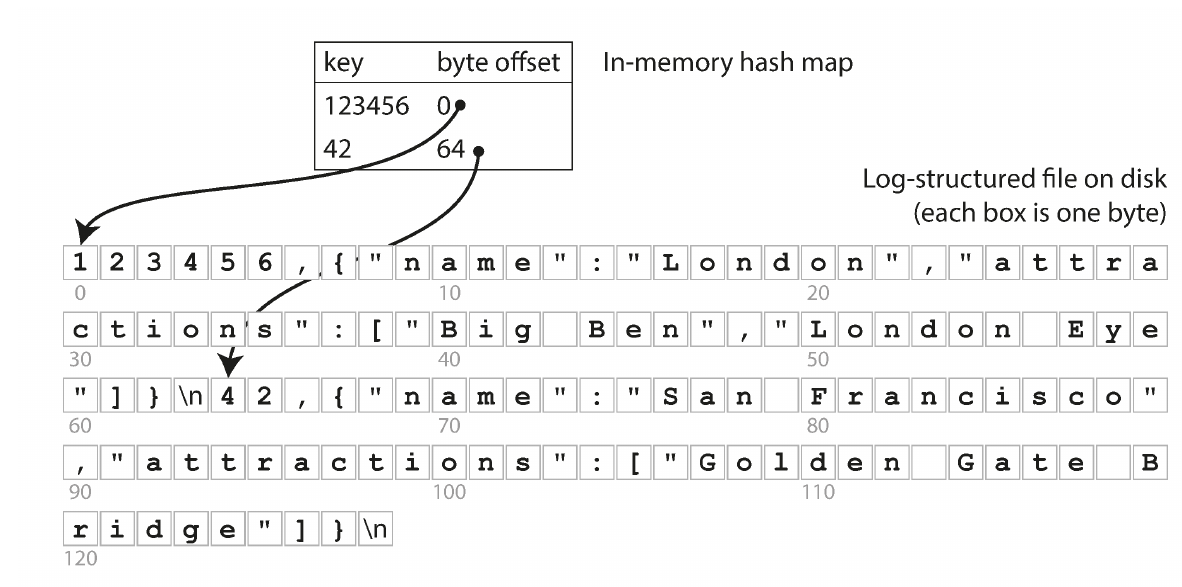

## 1.4

Nuestro modelo actual almacena información redundante, lo cual puede ser problemático al realizar muchas escrituras. Para optimizarlo, dividiremos las tablas en _segmentos_, cada uno con un número máximo de registros (100 en este caso). Estos segmentos permiten trabajar con regiones de datos más limitadas y, además, ofrecen la posibilidad de combinar periódicamente toda la información para eliminar registros duplicados.  

Un segmento debe implementar las operaciones de lectura y escritura como se hizo previamente, manteniendo su propio índice. Además, para facilitar la gestión, puedes implementar los siguientes métodos auxiliares en la clase `Segmento`:

- `claves_almacenadas() -> List[int]`: devuelve una lista con las claves almacenadas en el segmento. Estas claves corresponden a las presentes en el índice.
- `escrituras_realizadas() -> int`: indica cuántos elementos contiene actualmente el segmento.

Por otro lado, implementaremos la clase `Tabla1_4`, que será responsable de gestionar todos los segmentos de una tabla específica. Esta clase manejará el proceso de lectura y escritura de la tabla utilizando los segmentos. Ten en cuenta los siguientes puntos clave:

- La operación `escribir()` escribirá directamente en el último segmento creado, siempre que este no haya alcanzado el límite máximo de registros.
- La operación `leer()` consultará cada segmento en busca de la clave requerida. Si un segmento puede proporcionar la clave, se devolverá; de lo contrario, se continuará con el siguiente segmento.

La clase `Tabla1_4` debe crear un directorio (si no existe) para almacenar los archivos asociados a los segmentos de la tabla, y cargar todos los segmentos correspondientes. En el tutorial de Python (**Sección 11**), se incluye una guía sobre cómo manejar ficheros y directorios que puede ser útil para esta tarea.  

Para anotar cuál es el segmento más antiguo y cuál el más reciente, puedes optar por una de estas alternativas:

1. Mantener un archivo independiente que registre el orden de creación de los segmentos. Cada vez que se cree un nuevo segmento, su orden deberá ser anotado en este archivo.
2. Numerar los archivos asociados a los segmentos, asignando índices que representen su antigüedad (desde el más antiguo al más reciente). Cada nuevo segmento recibirá un índice coherente con este esquema.

Se recomienda implementar los siguientes métodos auxiliares:

- `_cargar_segmentos() -> List[Segmento]`: carga los segmentos existentes del directorio correspondiente.
- `_nuevo_segmento() -> Segmento`: crea un nuevo segmento siguiendo la alternativa de numeración o registro que hayas elegido.

## Consolidación de Tablas

Para hacer un uso efectivo de los segmentos, implementaremos la operación de _consolidación_. Esta operación consiste en combinar toda la información almacenada en nuestra tabla, quedándonos únicamente con el último valor introducido para cada clave.  

El siguiente diagrama ilustra cómo funciona el proceso de consolidación para dos segmentos:  

_Ejemplo con segmentos_

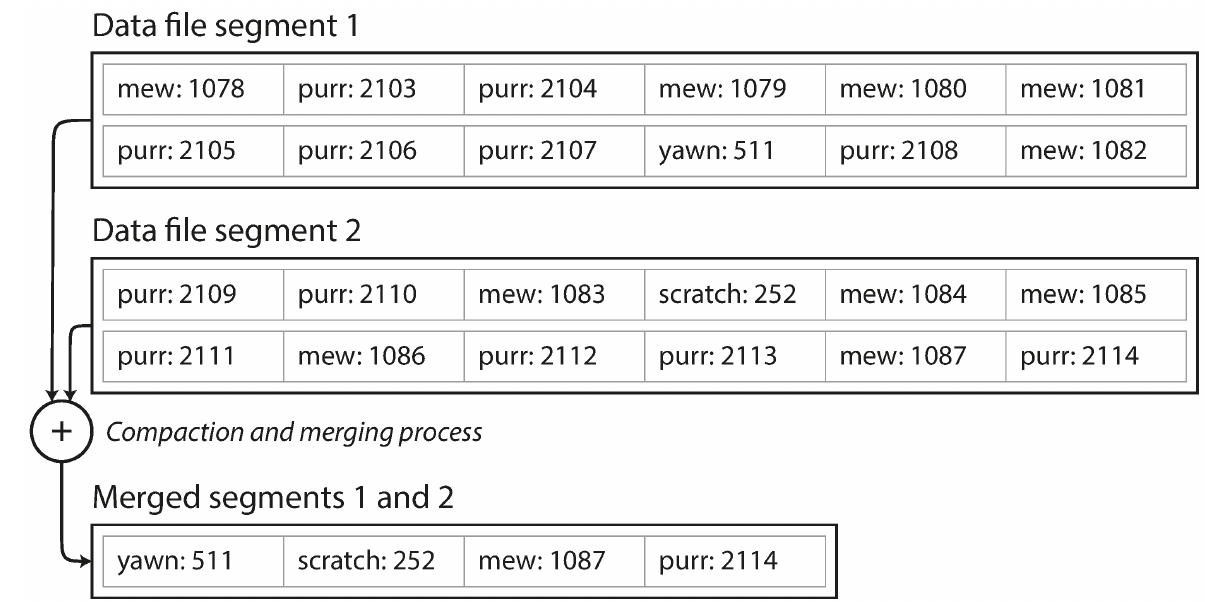

En nuestro caso, realizaremos la consolidación cada vez que se hayan generado **10** nuevos segmentos desde que se cargó la tabla o desde la última consolidación. También consolidaremos cuando se termine la conexión actual a la base de datos (es decir, cuando se borra el objeto tabla correspondiente). Para asociar una función al borrado de un objeto, investigad cómo funciona el método `weakref.finalize(funcion)` de la librería `weakref`.

Para llevar a cabo el proceso de consolidación, seguiremos los pasos descritos a continuación:

1. **Registrar la posición del segmento actual:** Antes de iniciar la consolidación, guardaremos la posición del último segmento en la lista de segmentos que almacena la tabla.  
2. **Recorrer los segmentos:**  
   - Iteraremos desde el segmento más reciente hasta el más antiguo, recuperando los valores que aún no hayan sido consolidados. Según vayamos detectando estos valores, los escribiremos en un nuevo segmento. Para detectar qué valores no se han consolidado aún, podemos guardar la lista de claves que hemos escrito en un diccionario (con valores nulos) y preguntar si está en ese diccionario utilizando el método `valor in diccionario`.

3. **Eliminar archivos antiguos:**  
   - Borraremos todos los archivos asociados a los segmentos que hayan sido consolidados.  
   - Actualizaremos nuestra lista de segmentos reemplazándola por la nueva sublista generada durante el proceso de consolidación.  

Es importante tener cuidado durante el recorrido de los segmentos, ya que, conforme se consoliden los registros, se irán generando nuevos segmentos. Por este motivo, es esencial guardar la posición del último segmento previo al inicio de la consolidación.  

## 1.5

Con las implementaciones de `Tabla1_2`, `Tabla1_3` y `Tabla1_4`, ejecutad ejemplos que comparen su rendimiento. Implementad un script que reproduzca las mismas operaciones desde el mismo archivo para cada implementación y estudie los tiempos globales de lectura y escritura.

Con esta información, responded a las siguientes preguntas (en una archivo de texto independiente):

- ¿Qué ocurre si se hacen muchas más lecturas que escrituras? ¿Y en caso contrario?
- ¿Cómo se comportan las distintas implementaciones si se realizan múltiples escrituras al mismo conjunto de claves de forma repetida?


**OPCIONAL**: Podéis implementar un script que conecte los métodos de generación de comandos con las mediciones de tiempo de las tablas, controlando cómo varían distintos parámetros para realizar la comparación de forma automática.

## Instrucciones de Entrega:

Subid al campus virtual un archivo `.zip` que contenga los siguientes archivos: el archivo `.py` con la implementación del apartado **1.4**, un archivo de texto para responder al ejercicio **1.5** y opcionalmente, el/los script(s) adicionales para comparar las implementaciones de forma automática (generación de ejemplos variando parámetros).